# Pre-requisites

In [1]:
# Install required libraries (if not already installed)
!pip install pytorch-lightning wandb  > /dev/null 2>&1
!pip install pytorch-lightning -U -qq  > /dev/null 2>&1
!pip install torchmetrics -U -qq > /dev/null 2>&1
!pip install fastdownload -U -qq > /dev/null 2>&1
!pip install fastai -U -qq > /dev/null 2>&1
!pip install wandb -U -qq > /dev/null 2>&1

# Import libraries
import os
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader, random_split, Dataset
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import torchmetrics
import wandb
from pytorch_lightning.loggers import WandbLogger
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
from datetime import datetime
import seaborn as sns
from pytorch_lightning import seed_everything
from pytorch_lightning.tuner import Tuner
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
import gc
import shutil
from pathlib import Path
import sys
import zipfile
from tqdm.notebook import tqdm
from google.colab import drive
import re


# **Parameter Setup**

In [10]:
# Get today's date and format as MMDD
today = datetime.today()
date_suffix = today.strftime("%m%d")

# Construct the run name
current_run_name = f'DR-EB3-mc_lr-1e-5_{date_suffix}'
print("This run will be reffered as: ",current_run_name)

This run will be reffered as:  DR-EB3-mc_lr-1e-5_1106


In [11]:
# Hyperparameters
BATCH_SIZE = 64

my_best_model_path = '/content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/DR-EB3-mc-1023/stage6/epoch=27-val_loss=1.13.ckpt'

train_image_folder = '/content/data/train'

myWandblogger_project_name = current_run_name

project_dir = '/content/drive/MyDrive/sidmeister/modular_dl/kaggleDR'
if not os.path.isdir('/content/drive'):
        drive.mount('/content/drive')
checkpoint_dir = f'{project_dir}/checkpoints/{current_run_name}'
os.makedirs(checkpoint_dir, exist_ok=True)

layers_to_unfreeze = ['classifier']
my_top_k_models = 5 # save the top k models from each stage

In [12]:
my_EarlyStopping_Patience = 9 #for early stopping
my_EarlyStopping_min_delta = 0.001

my_scheduler_patience = 4
my_scheduler_factor = 0.5
my_scheduler_min_lr = 1e-6


	The stages list defines each training stage with:
	  •	name: Stage name.
	  •	layers_to_unfreeze: Layers to unfreeze in this stage.
	  •	learning_rate: Learning rate for this stage.
	  •	num_epochs: Number of epochs to train in this stage.

In [13]:
# List of stages with layers to unfreeze and learning rates
stages = [
    {'name': 'classifier', 'layers_to_unfreeze': None, 'learning_rate': 1e-5, 'num_epochs': 20},
    {'name': 'stage8', 'layers_to_unfreeze': ['features.8'], 'learning_rate': 1e-5, 'num_epochs': 25},
    {'name': 'stage7', 'layers_to_unfreeze': ['features.8', 'features.7'], 'learning_rate': 1e-5, 'num_epochs': 30},
    {'name': 'stage6', 'layers_to_unfreeze': ['features.8', 'features.7', 'features.6'], 'learning_rate': 1e-5, 'num_epochs': 40},
    {'name': 'stage5', 'layers_to_unfreeze': ['features.8', 'features.7', 'features.6', 'features.5'], 'learning_rate': 1e-5, 'num_epochs': 40}
    # Add more stages as needed
]

best_model_path = my_best_model_path

In [14]:
x = 5e-5
x+1

1.00005

In [15]:
#close any running instance of wandb
try:
    wandb.finish()
except wandb.errors.UsageError as e:
    print(f"Error closing Wandb: {e}")

# Core

## Model Definition

In [16]:
# Load the pre-trained EfficientNet-B3 model
model = models.efficientnet_b3(weights='IMAGENET1K_V1')


Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 221MB/s]


In [17]:
model.classifier[1]

Linear(in_features=1536, out_features=1000, bias=True)

In [18]:

# Modify the classifier
num_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(256, 5)
)

# Check for GPU availability and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the appropriate device
model.to(device);
# to prevent displaying the entire model

## DRDataset : Custom dataset class

In [19]:
class DRDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get image info
        row = self.df.iloc[idx]
        image_name = f"{row['patient_id']}_{row['eye']}_level{row['level']}.jpeg"
        image_path = os.path.join(self.img_dir, image_name)

        # Load image
        image = Image.open(image_path).convert('RGB')

        # Apply transforms
        if self.transform:
            image = self.transform(image)

        # Get label
        label = row['level']

        return image, label

In [20]:
#

## Image Transformations

In [21]:
# Define image transformations
IMG_SIZE = 300
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

valid_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

## DRClassifier - PyTorch Lightening Module

In [22]:
class DRClassifier(pl.LightningModule):
    def __init__(self, model, class_weights, learning_rate=1e-3):
        super().__init__()
        self.model = model  # The pre-trained EfficientNet-B3 model with a custom classifier
        self.criterion = nn.CrossEntropyLoss(weight=class_weights)  # Loss function with class weights
        self.learning_rate = learning_rate  # Initial learning rate

        # Metrics to track accuracy for training and validation
        self.train_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=5)
        self.val_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=5)

    def forward(self, x):
        """ Forward pass through the model """
        return self.model(x)

    def training_step(self, batch, batch_idx):
        """
        Defines the training loop logic.
        - Forward pass
        - Compute loss and accuracy
        - Log metrics
        """
        images, labels = batch
        images = images.to(self.device)
        labels = labels.to(self.device).long()

        # Forward pass
        outputs = self(images)
        loss = self.criterion(outputs, labels)

        # Compute accuracy
        preds = torch.argmax(outputs, dim=1)
        acc = self.train_accuracy(preds, labels)

        # Log metrics
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('train_acc', acc, on_step=False, on_epoch=True, prog_bar=True)

        # Log learning rate
        optimizer = self.optimizers()
        lr = optimizer.param_groups[0]['lr']  # Extract the learning rate
        self.log('learning_rate', lr, on_step=False, on_epoch=True, prog_bar=True)  # Log the learning rate

        return loss

    def validation_step(self, batch, batch_idx):
        """
        Defines the validation loop logic.
        - Forward pass
        - Compute loss and accuracy
        - Log metrics
        """
        images, labels = batch
        images = images.to(self.device)
        labels = labels.to(self.device).long()

        # Forward pass
        outputs = self(images)
        loss = self.criterion(outputs, labels)

        # Compute accuracy
        preds = torch.argmax(outputs, dim=1)
        acc = self.val_accuracy(preds, labels)

        # Log metrics
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_acc', acc, on_step=False, on_epoch=True, prog_bar=True)

        return loss

    def configure_optimizers(self):
        """
        Defines the optimizer and learning rate scheduler.
        """
        # Adam optimizer with filtered parameters (only those that require gradients)
        optimizer = Adam(filter(lambda p: p.requires_grad, self.parameters()), lr=self.learning_rate)

        # Learning rate scheduler that reduces learning rate when validation loss plateaus
        scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=my_scheduler_patience, factor=my_scheduler_factor , min_lr=my_scheduler_min_lr)

        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_loss',
                'interval': 'epoch',
                'frequency': 1,
                'strict': True
            }
        }

In [23]:
best_model_path

'/content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/DR-EB3-mc-1023/stage6/epoch=27-val_loss=1.13.ckpt'

## Dataset Loading Function


	•	Mount Google Drive only if it’s not already mounted.
	•	For each dataset in dataset_names:
	•	Check if the dataset folder exists in the local directory.
	•	If it exists, print a message indicating that it’s already present.
	•	If not, check if the zip file is already copied locally.
	•	If not, copy the zip file from Google Drive.
	•	If the zip file is not in Google Drive, print a warning and skip to the next dataset.
	•	Extract the zip file to the dataset folder.
	•	Remove the zip file after extraction to save space.

In [24]:
def load_dataset(dataset_names, dataset_dir='/content/dataset', drive_dataset_dir='/content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/dataset'):
    """
    Checks if the specified datasets are present in the local dataset directory.
    If not, copies the zip files from Google Drive, extracts them, and prepares the datasets.

    Args:
        dataset_names (list): List of dataset names to load (e.g., ['train', 'valid', 'test']).
        dataset_dir (str): Local directory where datasets are stored.
        drive_dataset_dir (str): Directory in Google Drive where datasets are stored.
    """
    # Mount Google Drive if not already mounted
    if not os.path.isdir('/content/drive'):
        drive.mount('/content/drive')

    os.makedirs(dataset_dir, exist_ok=True)

    for dataset_name in dataset_names:
        dataset_folder = os.path.join(dataset_dir, dataset_name)
        if os.path.exists(dataset_folder):
            print(f"{dataset_name} dataset is already present.")
        else:
            # Check if the zip file is already copied locally
            zip_file_name = f"{dataset_name}.zip"
            local_zip_path = os.path.join(dataset_dir, zip_file_name)
            if not os.path.exists(local_zip_path):
                # Copy zip file from Google Drive
                drive_zip_path = os.path.join(drive_dataset_dir, zip_file_name)
                if os.path.exists(drive_zip_path):
                    print(f"Copying {zip_file_name} from Google Drive...")
                    shutil.copy2(drive_zip_path, local_zip_path)
                else:
                    print(f"Zip file {zip_file_name} not found in Google Drive at {drive_zip_path}.")
                    continue  # Skip this dataset

            # Extract the zip file
            print(f"Extracting {zip_file_name}...")
            with zipfile.ZipFile(local_zip_path, 'r') as zip_ref:
                zip_ref.extractall(dataset_folder)
            print(f"{dataset_name} dataset is ready.")

            # Optionally, remove the zip file to save space
            os.remove(local_zip_path)

In [25]:
def parse_filenames(folder_path):
    """
    Parses filenames in the dataset folder and creates a dataframe with columns:
    'image', 'level', 'patient_id', 'eye'.

    Args:
        folder_path (str): Path to the folder containing the images.

    Returns:
        pd.DataFrame: Dataframe with columns: 'image', 'level', 'patient_id', 'eye'.
    """
    data = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.jpeg'):
            # Expected filename format: {patient_id}_{eye}_level{level}.jpeg
            match = re.match(r'(\d+)_(left|right)_level(\d+)\.jpeg', filename)
            if match:
                patient_id = int(match.group(1))
                eye = match.group(2)
                level = int(match.group(3))
                image_name = filename  # Or filename without extension if needed
                data.append({
                    'image': image_name,
                    'level': level,
                    'patient_id': patient_id,
                    'eye': eye
                })
            else:
                print(f"Filename {filename} does not match expected format.")

    return pd.DataFrame(data)

# Training

## Setup Training and Validation Datatsets

In [26]:
# Load required datasets
load_dataset(['train', 'valid'])

# Define data directories
train_data_dir = '/content/dataset/train'
valid_data_dir = '/content/dataset/valid'

# Parse filenames to create dataframes
train_df = parse_filenames(train_data_dir)
valid_df = parse_filenames(valid_data_dir)

# Create datasets
train_dataset = DRDataset(df=train_df, img_dir=train_data_dir, transform=train_transforms)
valid_dataset = DRDataset(df=valid_df, img_dir=valid_data_dir, transform=valid_transforms)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

Copying train.zip from Google Drive...
Extracting train.zip...
train dataset is ready.
Copying valid.zip from Google Drive...
Extracting valid.zip...
valid dataset is ready.


## Compute Class Weights

In [27]:
# Compute class weights
labels = train_df['level'].values
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float)
print("Class Weights:", class_weights)

Class Weights: tensor([0.2721, 2.8792, 1.3276, 8.0484, 9.9345])


## Function for Freezing and Unfreezing Layers
The function set_parameter_requires_grad freezes all parameters and then unfreezes only the specified layers.

In [28]:
def set_parameter_requires_grad(model, layers_to_unfreeze=None):
    """
    Freeze all layers in the model except those in layers_to_unfreeze.
    The classifier is always unfrozen by default.

    Args:
        model (nn.Module): The model.
        layers_to_unfreeze (list of str): List of layer names to unfreeze.
    """
    # First, freeze all layers
    for param in model.parameters():
        param.requires_grad = False
    print('All layers are now frozen', end = '')

    # Always unfreeze the classifier
    for param in model.classifier.parameters():
        param.requires_grad = True
    print('; Except for Classifier', end='')

    # If layers_to_unfreeze is provided, unfreeze specified layers
    if layers_to_unfreeze:
        for name, module in model.named_modules():
            if any(layer_name in name for layer_name in layers_to_unfreeze):
                for param in module.parameters():
                    param.requires_grad = True
        print(f' and {layers_to_unfreeze}.')
    else:
        print('.')

## Training Function for each stage


	•	The function train_model_stage takes in various parameters and trains the model for one stage.
	•	It sets the requires_grad for the specified layers.
	•	It initializes the DRClassifier with the updated model.
	•	It defines callbacks for checkpointing and early stopping.
	•	It trains the model and returns the path to the best model.

In [29]:
def train_model_stage(model, train_loader, valid_loader, class_weights, learning_rate, layers_to_unfreeze, num_epochs, stage_name):
    # Set requires_grad for layers
    set_parameter_requires_grad(model, layers_to_unfreeze)

    # Move class_weights to the correct device before instantiating DRClassifier
    class_weights = class_weights.to(device)  # Use the global 'device' variable

    # Instantiate the LightningModule
    dr_classifier = DRClassifier(model=model, class_weights=class_weights)
    dr_classifier.learning_rate = learning_rate

    checkpoint_dir_stage = f'{checkpoint_dir}/{stage_name}'
    os.makedirs(checkpoint_dir_stage, exist_ok=True)

    # Define callbacks
    checkpoint_callback = ModelCheckpoint(
        dirpath= checkpoint_dir_stage,
        filename='{epoch:02d}-{val_loss:.2f}',
        save_top_k= my_top_k_models, #Save only the top k models
        verbose=False,
        monitor='val_loss',
        mode='min',
        save_weights_only=False,  # Save the entire model, not just weights
        every_n_epochs=1  # Save after every epoch
    )
    early_stopping_callback = EarlyStopping(
        monitor='val_loss',
        patience = my_EarlyStopping_Patience,
        min_delta = my_EarlyStopping_min_delta,
        verbose=True,
        mode='min'
    )
    # Initialize WandbLogger
    wandb_logger = WandbLogger(
        project= myWandblogger_project_name,  # Set your Wandb project name here
        name=f'{stage_name} learning',  # Run name includes the current stage
        log_model='best'  # Log all model checkpoints
    )

    # Define the trainer
    trainer = pl.Trainer(
        max_epochs=num_epochs,
        callbacks=[checkpoint_callback, early_stopping_callback],
        accelerator="gpu" if torch.cuda.is_available() else "cpu",
        devices=1 if torch.cuda.is_available() else None,
        logger=wandb_logger,
        detect_anomaly=True
    )

    # Train the model
    trainer.fit(dr_classifier, train_loader, valid_loader)

    # Properly close Wandb run
    try:
        wandb.finish()
    except wandb.errors.UsageError as e:
        print(f"Error closing Wandb: {e}")

    # Return the path and epoch of the best model
    best_model_path = checkpoint_callback.best_model_path
    return best_model_path

In [30]:
try:
  wandb.finish()
except wandb.errors.UsageError as e:
    print(f"Error closing Wandb: {e}")

from google.colab import userdata

# Log in to wandb using the API key stored in colab
wandb.login(key=userdata.get('wandb'))

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Training Loop


	The loop goes through each stage:
	  •	If there’s a best_model_path from the previous stage, it loads that model’s weights.
	  •	It calls train_model_stage to train for the current stage.
	  •	Updates best_model_path with the path to the best model from this stage.

In [31]:
best_model_path = my_best_model_path

In [ ]:
for stage in stages:
    print(f"Starting {stage['name']}...")

    # If there's a best model from previous stage, load it
    if best_model_path:
        # Load the best model weights
        dr_classifier = DRClassifier.load_from_checkpoint(
            checkpoint_path=best_model_path,
            model=model,
            class_weights=class_weights
        )
        model = dr_classifier.model  # Update the model with loaded weights
        model.to(device)
        print(f"Loaded best model from {best_model_path}")

    # Train the model for this stage
    best_model_path = train_model_stage(
        model=model,
        train_loader=train_loader,
        valid_loader=valid_loader,
        class_weights=class_weights,
        learning_rate=stage['learning_rate'],
        layers_to_unfreeze=stage['layers_to_unfreeze'],
        num_epochs=stage['num_epochs'],
        stage_name=stage['name']
    )
    best_epoch = 999

    try:
      match = re.search(r'epoch=(\d+)', best_model_path)
      if match:
        best_epoch = match.group(1)
    except Exception as e:
    # Handle the case where the extraction fails
      print("Failed to extract Best Epoch:", e)


    # Output the best model information
    print(f"Best model saved from Epoch number {best_epoch} at {best_model_path}")

Starting classifier...


INFO:pytorch_lightning.utilities.rank_zero:You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA L4') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
wandb: Currently logged in as: aiml-gopi (gopi-corp). Use `wandb login --relogin` to force relogin


Loaded best model from /content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/DR-EB3-mc-1023/stage6/epoch=27-val_loss=1.13.ckpt
All layers are now frozen; Except for Classifier.


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | model          | EfficientNet       | 11.1 M | train
1 | criterion      | CrossEntropyLoss   | 0      | train
2 | train_accuracy | MulticlassAccuracy | 0      | train
3 | val_accuracy   | MulticlassAccuracy | 0      | train
--------------------------------------------------------------
394 K     Trainable params
10.7 M    Non-trainable params
11.1 M    Total params
44.364    Total estimated model params size (MB)
539       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 1.154


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 1.152


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 1.150


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 1.149


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 1.144


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 9 records. Best score: 1.144. Signaling Trainer to stop.
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
learning_rate,████████████████▁▁▁▁
train_acc,▆▁▄▄▂▆█▄▄▆▆▆▃▁▅█▇▆▄▂
train_loss,▄▅▃▅▄▃▆▄▃▄▁▅█▆▃▅▄▃▇▃
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
val_acc,▄▁▃▄▅█▅▃▅▅▃▆▂▃▃▃▄▄▃▅
val_loss,▆▅▄▄▆█▄▆▄▃▁▆▁▄▃▂▂▂▃▃
epoch,19
learning_rate,1e-05
train_acc,0.47889
train_loss,1.10905


Best model saved from Epoch number 10 at /content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/DR-EB3-mc_lr-1e-5_1106/classifier/epoch=10-val_loss=1.14.ckpt
Starting stage8...


INFO:pytorch_lightning.utilities.rank_zero:You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Loaded best model from /content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/DR-EB3-mc_lr-1e-5_1106/classifier/epoch=10-val_loss=1.14.ckpt
All layers are now frozen; Except for Classifier and ['features.8'].


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | model          | EfficientNet       | 11.1 M | train
1 | criterion      | CrossEntropyLoss   | 0      | train
2 | train_accuracy | MulticlassAccuracy | 0      | train
3 | val_accuracy   | MulticlassAccuracy | 0      | train
--------------------------------------------------------------
987 K     Trainable params
10.1 M    Non-trainable params
11.1 M    Total params
44.364    Total estimated model params size (MB)
539       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 1.155


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 1.147


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 9 records. Best score: 1.147. Signaling Trainer to stop.


epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
learning_rate,████████████▁▁▁
train_acc,▇▇█▅▁▄▄▅▆▅▅▆▆▅▆
train_loss,▄▄▆▃▄▄▄▃█▄▅▃▅▅▁
trainer/global_step,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
val_acc,▃▁▇▁▄▁▃▆▅█▅▆▆▅▆
val_loss,▄▄▇▄▄▁▁▂▅▃▄▇█▂▄
epoch,14
learning_rate,1e-05
train_acc,0.49223
train_loss,1.09127


Best model saved from Epoch number 06 at /content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/DR-EB3-mc_lr-1e-5_1106/stage8/epoch=06-val_loss=1.15.ckpt
Starting stage7...


INFO:pytorch_lightning.utilities.rank_zero:You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Loaded best model from /content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/DR-EB3-mc_lr-1e-5_1106/stage8/epoch=06-val_loss=1.15.ckpt
All layers are now frozen; Except for Classifier and ['features.8', 'features.7'].


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | model          | EfficientNet       | 11.1 M | train
1 | criterion      | CrossEntropyLoss   | 0      | train
2 | train_accuracy | MulticlassAccuracy | 0      | train
3 | val_accuracy   | MulticlassAccuracy | 0      | train
--------------------------------------------------------------
4.3 M     Trainable params
6.8 M     Non-trainable params
11.1 M    Total params
44.364    Total estimated model params size (MB)
539       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 1.160


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 1.157


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 1.155


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 1.151


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 1.150


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 1.147


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 9 records. Best score: 1.147. Signaling Trainer to stop.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
learning_rate,██████████████████████▁▁▁▁
train_acc,▅▅▄▄▅▄▃▁▃▆▅▅▁▃▇▄▄▃▇▆▇▆█▇▅▅
train_loss,▃▇▂▆▄▃▃▃▄▁▁▄█▄▃▃▃▂▁▂▂▂▁▃▂▂
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
val_acc,▆▅▆▆▆▅▄▃▁▇▅▅▃▅▅▇▆▅▆▇█▇▇▆▅█
val_loss,▄▆▄▃▃▂▂▆▂▇▅▃▄▂▃▄▁▂▃▄▄█▆▃▂▇
epoch,25
learning_rate,1e-05
train_acc,0.48995
train_loss,1.09303


Best model saved from Epoch number 16 at /content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/DR-EB3-mc_lr-1e-5_1106/stage7/epoch=16-val_loss=1.15.ckpt
Starting stage6...


INFO:pytorch_lightning.utilities.rank_zero:You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Loaded best model from /content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/DR-EB3-mc_lr-1e-5_1106/stage7/epoch=16-val_loss=1.15.ckpt
All layers are now frozen; Except for Classifier and ['features.8', 'features.7', 'features.6'].


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | model          | EfficientNet       | 11.1 M | train
1 | criterion      | CrossEntropyLoss   | 0      | train
2 | train_accuracy | MulticlassAccuracy | 0      | train
3 | val_accuracy   | MulticlassAccuracy | 0      | train
--------------------------------------------------------------
8.9 M     Trainable params
2.2 M     Non-trainable params
11.1 M    Total params
44.364    Total estimated model params size (MB)
539       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 1.154


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 1.151


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 1.140


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 9 records. Best score: 1.140. Signaling Trainer to stop.


epoch,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇████
learning_rate,████████████▁▁▁▁
train_acc,▂▁▂▃▄▄▃▂█▅▆▅▃▃▄▄
train_loss,▆█▆█▅▆▄▄▂▄▂▁▁▁▂▂
trainer/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇████
val_acc,▄▄▇▇█▇▄▃▆▇▆▄▁▃▅▄
val_loss,▄▆▅▄▇▇▁▂█▇▇▄▄▆▇█
epoch,15
learning_rate,1e-05
train_acc,0.49675
train_loss,1.06193


Best model saved from Epoch number 06 at /content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/DR-EB3-mc_lr-1e-5_1106/stage6/epoch=06-val_loss=1.14.ckpt
Starting stage5...


INFO:pytorch_lightning.utilities.rank_zero:You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Loaded best model from /content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/DR-EB3-mc_lr-1e-5_1106/stage6/epoch=06-val_loss=1.14.ckpt
All layers are now frozen; Except for Classifier and ['features.8', 'features.7', 'features.6', 'features.5'].


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | model          | EfficientNet       | 11.1 M | train
1 | criterion      | CrossEntropyLoss   | 0      | train
2 | train_accuracy | MulticlassAccuracy | 0      | train
3 | val_accuracy   | MulticlassAccuracy | 0      | train
--------------------------------------------------------------
10.3 M    Trainable params
802 K     Non-trainable params
11.1 M    Total params
44.364    Total estimated model params size (MB)
539       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 1.136


# Evaluation

## Load Test Data

In [39]:
# Load test dataset
load_dataset(['test'])

# Define data directory
test_data_dir = '/content/dataset/test'

# Parse filenames to create dataframe
test_df = parse_filenames(test_data_dir)

# Create dataset
test_dataset = DRDataset(df=test_df, img_dir=test_data_dir, transform=valid_transforms)

# Create DataLoader
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

test dataset is already present.


## Load the best model

In [40]:
custom_model = '/content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/DR-EB3-mc-1104/stage6/epoch=06-val_loss=1.15.ckpt'

In [41]:
best_model_path = custom_model

In [42]:
cw = [0.2721, 2.8792, 1.3276, 8.0484, 9.9345]
class_weights = torch.tensor(cw, dtype=torch.float)

In [43]:
# Load the best model from the last stage
dr_classifier = DRClassifier.load_from_checkpoint(
    checkpoint_path=best_model_path,
    model=model,
    class_weights=class_weights
)
model = dr_classifier.model
model.to(device)
model.eval()
;

''

## Evaluate on test set

In [ ]:
# Collect predictions and true labels
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for batch in test_loader:
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        probs = nn.functional.softmax(outputs, dim=1)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

## Classification Report

In [ ]:
# Classification report
report = classification_report(all_labels, all_preds, target_names=['Level 0', 'Level 1', 'Level 2', 'Level 3', 'Level 4'])
print(report)

# Convert report to DataFrame for logging to wandb
report_dict = classification_report(all_labels, all_preds, target_names=['Level 0', 'Level 1', 'Level 2', 'Level 3', 'Level 4'], output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Log to wandb
#wandb_logger.experiment.log({"classification_report": wandb.Table(dataframe=report_df)})

## Confusion Matrix

In [ ]:
# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
cm_fig = plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Level 0', 'Level 1', 'Level 2', 'Level 3', 'Level 4'],
            yticklabels=['Level 0', 'Level 1', 'Level 2', 'Level 3', 'Level 4'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')

plt.show()

# Close the figure
plt.close(cm_fig)

## ROC Curves

In [ ]:
# Binarize the labels
all_labels_bin = label_binarize(all_labels, classes=[0, 1, 2, 3, 4])
all_probs = np.array(all_probs)

# Compute ROC AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], all_probs[:, i])
    roc_auc[i] = roc_auc_score(all_labels_bin[:, i], all_probs[:, i])

# Plot ROC curves
roc_fig = plt.figure()
for i in range(5):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curves for DR Levels')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

plt.show()

# Close the figure
plt.close(roc_fig)

# Other

## Function to free memory

In [ ]:
def free_memory():
    """
    Attempts to free up memory by deleting variables and running Python's garbage collector.
    """
    gc.collect()
    for device_id in range(torch.cuda.device_count()):
        torch.cuda.set_device(device_id)
        torch.cuda.empty_cache()
    gc.collect()

## Run One training and validation batch to check bugs

In [ ]:
# Load components
free_memory()
seed_everything(42)
model_config, data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()
# override default values
trainer_config['fast_dev_run']=True
model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=False, checkpointing=False, early_stopping=False)
dm.prepare_data()
trainer.fit(lightning_module, dm)

INFO:lightning_fabric.utilities.seed:Seed set to 42


NameError: name 'load_all_configs' is not defined

## Find Learning Rate

INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_w

Epoch 1: Val_Loss: 2.30, Val_Metric: 0.08 | 

Finding best initial lr:   0%|          | 0/30 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.tuner.lr_finder:Learning rate set to 0.0031622776601683794
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_0040228f-0599-4840-b176-4e1d81982b58.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_0040228f-0599-4840-b176-4e1d81982b58.ckpt


Train_Loss: 1.52, Train_Metric: 0.54
0.0031622776601683794


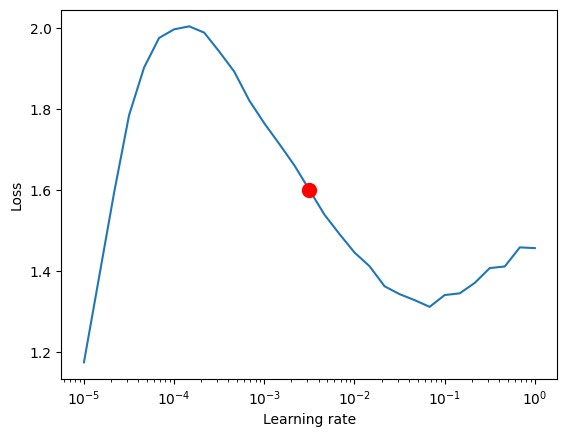

In [ ]:
# Load components
free_memory()
seed_everything(42)
model_config, data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()
# override default values
trainer_config['max_epochs']=5
data_module_config['data_module']['batch_size']=64

model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=False, checkpointing=False, early_stopping=False)
dm.setup()
tuner = Tuner(trainer)
lr_finder = tuner.lr_find(lightning_module, datamodule=dm, min_lr=1e-5, max_lr=1, num_training=30, mode='exponential')
fig = lr_finder.plot(suggest=True)
new_lr = lr_finder.suggestion()
print(new_lr)


## Scrapwork

In [ ]:
for name, module in model.named_modules():
    print(name)

## Old Dataset Setup


In [ ]:
#download data from kaggle competition
#!mkdir ~/.kaggle
#!cp /content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/env_files/.kaggle/kaggle.json ~/.kaggle/kaggle.json
#!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
# fast download dataset from kaggle competitions download -c diabetic-retinopathy-detection
#!kaggle competitions download -c diabetic-retinopathy-detection

In [ ]:
#copy downloaded dataset to base_folder/'modular_dl/kaggleDR/dataset/raw'
#!cp -r diabetic-retinopathy-detection.zip /content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/dataset/raw


In [ ]:
#unzip diabetic-retinopathy-detection.zip
#!unzip /content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/dataset/raw/diabetic-retinopathy-detection.zip -d /content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/dataset/unzip

In [ ]:
#concatenate zip parts together as train.zip
#!cat /content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/dataset/unzip/train.zip.* > /content/train.zip

In [ ]:
#copy train.zip to raw
!mkdir -p /content/data
!cp /content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/dataset/train_set/train.zip  /content/

In [ ]:
!mkdir -p /content/data
!unzip -q train.zip -d /content/data


In [ ]:
#copy trainlabels.csv.zip then extract and load
!mkdir -p /content/data
!cp /content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/dataset/unzip/trainLabels.csv.zip  /content
!unzip trainLabels.csv.zip -d /content/data

Archive:  trainLabels.csv.zip
  inflating: /content/data/trainLabels.csv  


In [ ]:
#count the number of files in content/data/train
!ls /content/data/train | wc -l

35126


In [ ]:
#load trainlabels.csv as dataset
import pandas as pd
df = pd.read_csv('/content/data/trainLabels.csv')
df.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


In [ ]:
# prompt: based on image column, add two more columns, patient_id and eye


def extract_patient_id_and_eye(image_name):
  """Extracts patient ID and eye information from the image name."""
  patient_id = image_name.split('_')[0]
  eye = image_name.split('_')[1]
  return patient_id, eye

# Add new columns to the DataFrame
df['patient_id'] = df['image'].apply(lambda x: extract_patient_id_and_eye(x)[0])
df['eye'] = df['image'].apply(lambda x: extract_patient_id_and_eye(x)[1])

df.head()


,image,level,patient_id,eye
0,10_left,0,10,left
1,10_right,0,10,right
2,13_left,0,13,left
3,13_right,0,13,right
4,15_left,1,15,left


## One time dataset split - TRAINvalTEST

In [ ]:
# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. Import Libraries
import os
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import zipfile

# 3. Load the DataFrame
#csv_path = '/content/data/trainLabels.csv'  # Update this path if necessary
#df = pd.read_csv(csv_path)
print(df.head())

# 4. Assign Representative Label to Each Patient
patient_df = df.groupby('patient_id').agg({'level': 'max'}).reset_index()
print(patient_df.head())

# 5. Split Patient IDs into Train, Validation, and Test Sets
train_ratio = 0.7
valid_ratio = 0.15
test_ratio = 0.15

# Split patients into train and temp sets
train_patients, temp_patients = train_test_split(
    patient_df,
    test_size=(1 - train_ratio),
    random_state=42,
    stratify=patient_df['level']
)

# Split temp into validation and test sets
valid_patients, test_patients = train_test_split(
    temp_patients,
    test_size=(test_ratio / (test_ratio + valid_ratio)),
    random_state=42,
    stratify=temp_patients['level']
)

print(f"Training patients: {len(train_patients)}")
print(f"Validation patients: {len(valid_patients)}")
print(f"Test patients: {len(test_patients)}")

# 6. Create DataFrames for Each Dataset Split
train_df = df[df['patient_id'].isin(train_patients['patient_id'])]
valid_df = df[df['patient_id'].isin(valid_patients['patient_id'])]
test_df = df[df['patient_id'].isin(test_patients['patient_id'])]

print(f"Training images: {len(train_df)}")
print(f"Validation images: {len(valid_df)}")
print(f"Test images: {len(test_df)}")

# 7. Create Directories
split_base_dir = '/content/data_split'
train_dir = os.path.join(split_base_dir, 'train')
valid_dir = os.path.join(split_base_dir, 'valid')
test_dir = os.path.join(split_base_dir, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(valid_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# 8. Copy Images with Renaming to Include Level
original_images_dir = '/content/data/train'

def copy_and_rename_images(df_subset, source_dir, dest_dir):
    for _, row in tqdm(df_subset.iterrows(), desc=f"Copying images to {os.path.basename(dest_dir)}", total=len(df_subset)):
        image_name = row['image']
        patient_id = row['patient_id']
        eye = row['eye']
        level = row['level']

        src = os.path.join(source_dir, image_name + '.jpeg')
        new_image_name = f"{patient_id}_{eye}_level{level}.jpeg"
        dst = os.path.join(dest_dir, new_image_name)

        if os.path.exists(src):
            shutil.copy2(src, dst)
        else:
            print(f"Image {src} not found.")

# Copy images for each set
copy_and_rename_images(train_df, original_images_dir, train_dir)
copy_and_rename_images(valid_df, original_images_dir, valid_dir)
copy_and_rename_images(test_df, original_images_dir, test_dir)

# 9. Zip Folders
def zip_folder(folder_path, zip_path):
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(folder_path):
            for file in tqdm(files, desc=f"Zipping {os.path.basename(folder_path)}"):
                file_path = os.path.join(root, file)
                zipf.write(file_path, arcname=os.path.relpath(file_path, start=folder_path))

train_zip_path = '/content/train.zip'
valid_zip_path = '/content/valid.zip'
test_zip_path = '/content/test.zip'

zip_folder(train_dir, train_zip_path)
zip_folder(valid_dir, valid_zip_path)
zip_folder(test_dir, test_zip_path)

# 10. Move Zip Files to Google Drive
drive_dest_dir = '/content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/dataset'
os.makedirs(drive_dest_dir, exist_ok=True)

def move_zip(zip_file_path, dest_dir):
    shutil.move(zip_file_path, dest_dir)

move_zip(train_zip_path, drive_dest_dir)
move_zip(valid_zip_path, drive_dest_dir)
move_zip(test_zip_path, drive_dest_dir)

print("Zip files have been moved to Google Drive.")

# 11. Clean Up Local Directories (Optional)
def remove_directory(dir_path):
    shutil.rmtree(dir_path)

remove_directory(split_base_dir)
print("Local directories have been cleaned up.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
      image  level patient_id    eye
0   10_left      0         10   left
1  10_right      0         10  right
2   13_left      0         13   left
3  13_right      0         13  right
4   15_left      1         15   left
  patient_id  level
0         10      0
1        100      0
2       1000      0
3      10003      0
4      10007      0
Training patients: 12294
Validation patients: 2634
Test patients: 2635
Training images: 24588
Validation images: 5268
Test images: 5270


Copying images to train:   0%|          | 0/24588 [00:00<?, ?it/s]

Copying images to valid:   0%|          | 0/5268 [00:00<?, ?it/s]

Copying images to test:   0%|          | 0/5270 [00:00<?, ?it/s]

Zipping train:   0%|          | 0/24588 [00:00<?, ?it/s]

Zipping valid:   0%|          | 0/5268 [00:00<?, ?it/s]

Zipping test:   0%|          | 0/5270 [00:00<?, ?it/s]

Zip files have been moved to Google Drive.
Local directories have been cleaned up.


In [ ]:
check how many patient_ids has different levels for different eyes.

# Group by patient_id and check if there are different levels for different eyes
patient_eye_level_counts = df.groupby(['patient_id', 'eye'])['level'].nunique()

# Find patients with different levels for different eyes
patients_with_different_levels = patient_eye_level_counts[patient_eye_level_counts > 1].index.get_level_values('patient_id').unique()

# Count the number of such patients
num_patients_different_levels = len(patients_with_different_levels)

print(f"Number of patients with different levels for different eyes: {num_patients_different_levels}")

Number of patients with different levels for different eyes: 0


## EDA

In [ ]:
#count the number of images in train dataset

#find out unique patient ID

#proportion of patients with both their eyes in dataset

#do both eyes have same level of DR

#setup labels in a csv

#vizualize dataset distribution

#Devise plan for managine imbalance if any

#

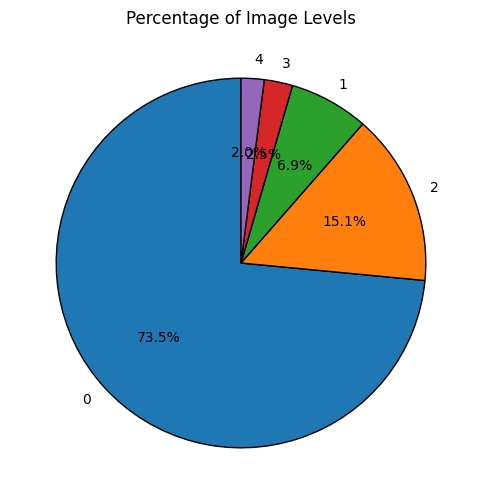

In [ ]:
# @title Percentage of image levels

import matplotlib.pyplot as plt

level_counts = train_df['level'].value_counts()

plt.figure(figsize=(8, 6))
plt.pie(level_counts, labels=level_counts.index, autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': 'black'})
_ = plt.title('Percentage of Image Levels')


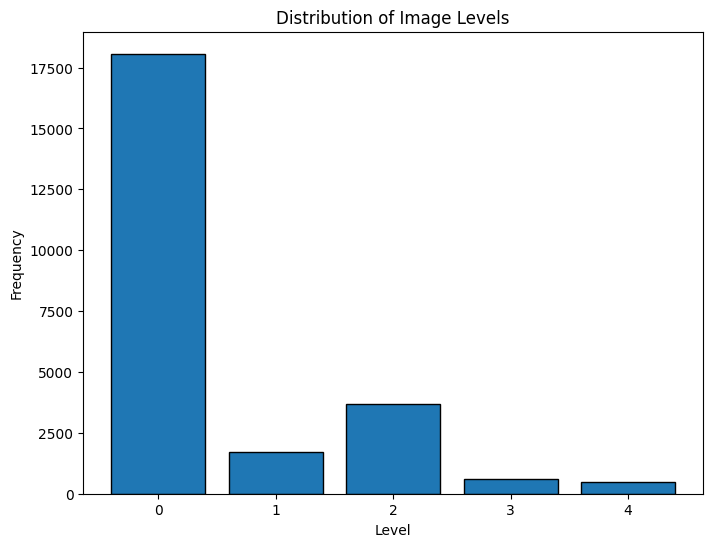

In [ ]:
# @title Distribution of Image Levels

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.hist(train_df['level'], bins=range(6), align='left', rwidth=0.8, edgecolor='black')
plt.xlabel('Level')
plt.ylabel('Frequency')
_ = plt.title('Distribution of Image Levels')

In [ ]:
#count the number of images in /content/data/train

train_image_folder = '/content/data/train'
image_count = len([name for name in os.listdir(train_image_folder) if os.path.isfile(os.path.join(train_image_folder, name))])

print(f"Number of images in {train_image_folder}: {image_count}")


Number of images in /content/data/train: 35126


In [ ]:
#count unique level frequency

unique_level_counts = train_df['level'].value_counts()
print(unique_level_counts)

level
0    18070
2     3704
1     1708
3      611
4      495
Name: count, dtype: int64


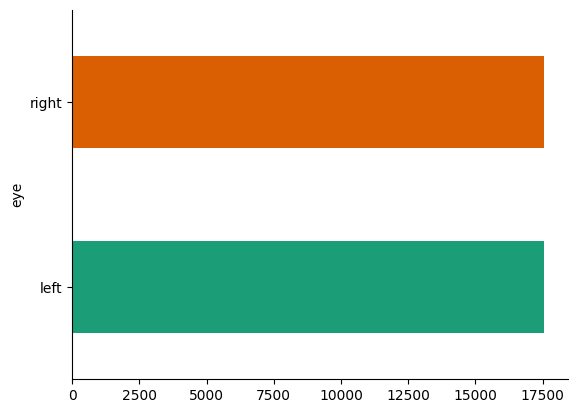

In [ ]:
# @title eye

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('eye').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# prompt: check how many patient_ids have only one eye in the dataset?

patient_eye_counts = train_df.groupby('patient_id')['eye'].nunique()
single_eye_patients = patient_eye_counts[patient_eye_counts == 1].count()
print(f"Number of patients with only one eye in the dataset: {single_eye_patients}")


Number of patients with only one eye in the dataset: 0


Level: 0


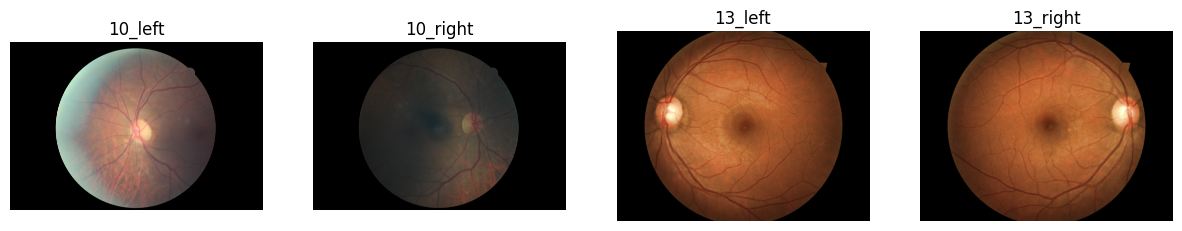

Level: 1


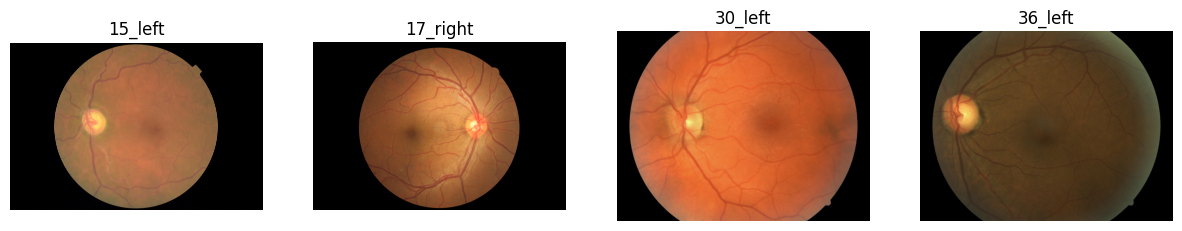

Level: 2


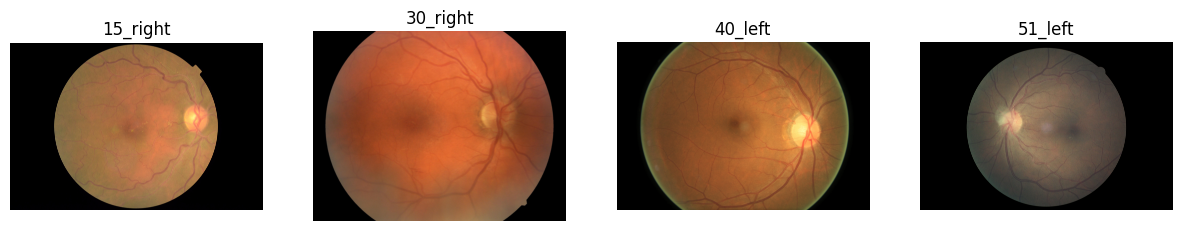

Level: 4


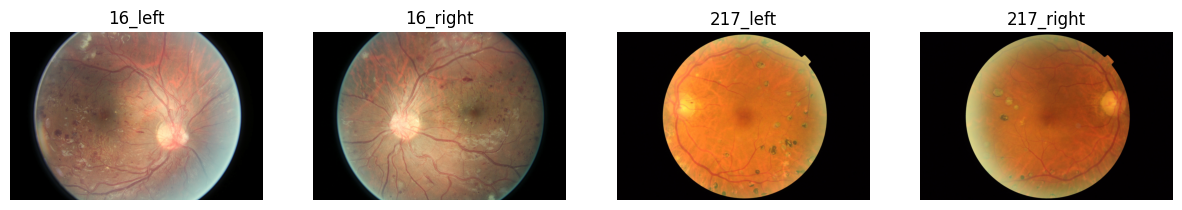

Level: 3


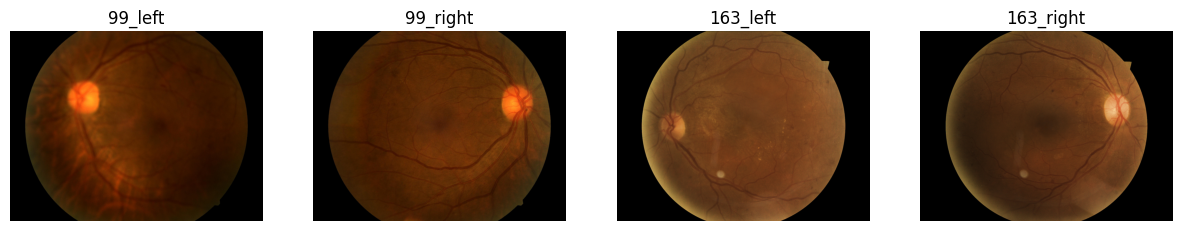

In [ ]:
# prompt: display 4 samples each of each of the levels with their filename

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Group the DataFrame by 'level'
for level in df['level'].unique():
  print(f"Level: {level}")
  # Get filenames for images with this level
  filenames = df[df['level'] == level]['image'].tolist()[:4]

  # Display images
  fig, axes = plt.subplots(1, len(filenames), figsize=(15, 5))
  for i, filename in enumerate(filenames):
      img_path = os.path.join(train_image_folder, filename + '.jpeg')
      try:
          img = mpimg.imread(img_path)
          axes[i].imshow(img)
          axes[i].set_title(filename)
          axes[i].axis('off')
      except FileNotFoundError:
          print(f"File not found: {img_path}")
  plt.show()



## Setup environment

In [ ]:
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')

    base_folder = Path(project_dir)
    data_folder = Path('/content')

else:
    base_folder = Path('base_folder path error')
    data_folder = Path('data_folder path error')


Mounted at /content/drive


In [ ]:
custom_function_folder = base_folder/'modular_dl/custom-functions/'
model_folder = base_folder/'modular_dl/kaggleDR/model'
model_folder.mkdir(parents=True, exist_ok=True)
project_folder = base_folder/'kaggleDR'
kaggle_api_folder = base_folder/'modular_dl/kaggleDR/env_files/.kaggle'
sys.path.append(str(project_folder))
sys.path.append(str(custom_function_folder))

## Extracting Zip Files and Parsing Filenames

In [ ]:
# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. Import Libraries
import os
import zipfile
import pandas as pd
from tqdm.notebook import tqdm
import re

# 3. Define Paths
drive_dataset_dir = '/content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/dataset'
local_dataset_dir = '/content/dataset'

# Create local directories
os.makedirs(local_dataset_dir, exist_ok=True)

# 4. Copy Zip Files from Google Drive to Colab
zip_files = ['train.zip', 'valid.zip', 'test.zip']
for zip_file in zip_files:
    src = os.path.join(drive_dataset_dir, zip_file)
    dst = os.path.join(local_dataset_dir, zip_file)
    if os.path.exists(src):
        print(f"Copying {zip_file} to local directory...")
        shutil.copy2(src, dst)
    else:
        print(f"Zip file {src} not found.")

# 5. Extract Zip Files
def extract_zip(zip_file_path, extract_to_folder):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        print(f"Extracting {os.path.basename(zip_file_path)}...")
        zip_ref.extractall(extract_to_folder)

for zip_file in zip_files:
    zip_path = os.path.join(local_dataset_dir, zip_file)
    extract_to = os.path.join(local_dataset_dir, os.path.splitext(zip_file)[0])
    os.makedirs(extract_to, exist_ok=True)
    extract_zip(zip_path, extract_to)

# 6. Parse Filenames to Create DataFrames
def parse_filenames(folder_path):
    data = []
    for filename in tqdm(os.listdir(folder_path), desc=f"Parsing filenames in {os.path.basename(folder_path)}"):
        if filename.endswith('.jpeg'):
            # Expected filename format: {patient_id}_{eye}_level{level}.jpeg
            match = re.match(r'(\d+)_(left|right)_level(\d+)\.jpeg', filename)
            if match:
                patient_id = int(match.group(1))
                eye = match.group(2)
                level = int(match.group(3))
                image_name = f"{patient_id}_{eye}"
                data.append({
                    'image': image_name,
                    'level': level,
                    'patient_id': patient_id,
                    'eye': eye
                })
            else:
                print(f"Filename {filename} does not match expected format.")
    return pd.DataFrame(data)

# Create DataFrames for each dataset
train_folder = os.path.join(local_dataset_dir, 'train')
valid_folder = os.path.join(local_dataset_dir, 'valid')
test_folder = os.path.join(local_dataset_dir, 'test')

train_df = parse_filenames(train_folder)
valid_df = parse_filenames(valid_folder)
test_df = parse_filenames(test_folder)

# 7. Display DataFrames
print("Training DataFrame:")
print(train_df.head())

print("Validation DataFrame:")
print(valid_df.head())

print("Test DataFrame:")
print(test_df.head())

# 8. Optional: Save DataFrames to CSV Files
train_df.to_csv('train_labels.csv', index=False)
valid_df.to_csv('valid_labels.csv', index=False)
test_df.to_csv('test_labels.csv', index=False)

print("DataFrames have been saved to CSV files.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Copying train.zip to local directory...
Copying valid.zip to local directory...
Copying test.zip to local directory...
Extracting train.zip...
Extracting valid.zip...
Extracting test.zip...


Parsing filenames in train:   0%|          | 0/24588 [00:00<?, ?it/s]

Parsing filenames in valid:   0%|          | 0/5268 [00:00<?, ?it/s]

Parsing filenames in test:   0%|          | 0/5270 [00:00<?, ?it/s]

Training DataFrame:
        image  level  patient_id    eye
0   3185_left      0        3185   left
1  37948_left      0       37948   left
2  5456_right      0        5456  right
3  6144_right      0        6144  right
4   5421_left      0        5421   left
Validation DataFrame:
         image  level  patient_id    eye
0   33137_left      0       33137   left
1   30502_left      0       30502   left
2  15761_right      0       15761  right
3   38322_left      0       38322   left
4   38127_left      2       38127   left
Test DataFrame:
         image  level  patient_id    eye
0   13027_left      0       13027   left
1   7506_right      0        7506  right
2  11222_right      0       11222  right
3  22368_right      0       22368  right
4   14173_left      0       14173   left
DataFrames have been saved to CSV files.
